# Exploring FIFA 17 Dataset

## Importation, Setup, Read...

### Import Python Modules

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import math

import seaborn as sns

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [111]:
plt.style.use('fivethirtyeight') #FiveThirtyEight.com Style

### Read Data

In [112]:
df_players = pd.read_csv('fifa_full.csv')

In [113]:
df_players.head(5)

,Name,Nationality,National_Position,National_Kit,Club,Club_Position,Club_Kit,Club_Joining,Contract_Expiry,Rating,...,Long_Shots,Curve,Freekick_Accuracy,Penalties,Volleys,GK_Positioning,GK_Diving,GK_Kicking,GK_Handling,GK_Reflexes
0,Cristiano Ronaldo,Portugal,LS,7.0,Real Madrid,LW,7.0,07/01/2009,2021.0,94,...,90,81,76,85,88,14,7,15,11,11
1,Lionel Messi,Argentina,RW,10.0,FC Barcelona,RW,10.0,07/01/2004,2018.0,93,...,88,89,90,74,85,14,6,15,11,8
2,Neymar,Brazil,LW,10.0,FC Barcelona,LW,11.0,07/01/2013,2021.0,92,...,77,79,84,81,83,15,9,15,9,11
3,Luis Suárez,Uruguay,LS,9.0,FC Barcelona,ST,9.0,07/11/2014,2021.0,92,...,86,86,84,85,88,33,27,31,25,37
4,Manuel Neuer,Germany,GK,1.0,FC Bayern,GK,1.0,07/01/2011,2021.0,92,...,16,14,11,47,11,91,89,95,90,89


## Data Engineering

### Account for Missing Values

In [114]:
missing_values = df_players.isnull().sum()/len(df_players)*100

In [115]:
missing_values

Name                   0.000000
Nationality            0.000000
National_Position     93.887878
National_Kit          93.887878
Club                   0.000000
Club_Position          0.005686
Club_Kit               0.005686
Club_Joining           0.005686
Contract_Expiry        0.005686
Rating                 0.000000
Height                 0.000000
Weight                 0.000000
Preffered_Foot         0.000000
Birth_Date             0.000000
Age                    0.000000
Preffered_Position     0.000000
Work_Rate              0.000000
Weak_foot              0.000000
Skill_Moves            0.000000
Ball_Control           0.000000
Dribbling              0.000000
Marking                0.000000
Sliding_Tackle         0.000000
Standing_Tackle        0.000000
Aggression             0.000000
Reactions              0.000000
Attacking_Position     0.000000
Interceptions          0.000000
Vision                 0.000000
Composure              0.000000
Crossing               0.000000
Short_Pa

Delete columns missing majority of data. Nationality columns have ~90% of data missing.

In [116]:
df_players.drop(df_players.columns[[2,3]], axis = 1, inplace = True)
df_players.dropna(how='any', inplace = True)

Separate DataFrame into GKs and non-GKs due to distinct skillsets.

In [117]:
df_gks = df_players[df_players['Preffered_Position'] == 'GK']
df_gks.reset_index(drop = True)
df_players = df_players[df_players['Preffered_Position'] != 'GK']
df_players.reset_index(drop = True)


,Name,Nationality,Club,Club_Position,Club_Kit,Club_Joining,Contract_Expiry,Rating,Height,Weight,...,Long_Shots,Curve,Freekick_Accuracy,Penalties,Volleys,GK_Positioning,GK_Diving,GK_Kicking,GK_Handling,GK_Reflexes
0,Cristiano Ronaldo,Portugal,Real Madrid,LW,7.0,07/01/2009,2021.0,94,185 cm,80 kg,...,90,81,76,85,88,14,7,15,11,11
1,Lionel Messi,Argentina,FC Barcelona,RW,10.0,07/01/2004,2018.0,93,170 cm,72 kg,...,88,89,90,74,85,14,6,15,11,8
2,Neymar,Brazil,FC Barcelona,LW,11.0,07/01/2013,2021.0,92,174 cm,68 kg,...,77,79,84,81,83,15,9,15,9,11
3,Luis Suárez,Uruguay,FC Barcelona,ST,9.0,07/11/2014,2021.0,92,182 cm,85 kg,...,86,86,84,85,88,33,27,31,25,37
4,Robert Lewandowski,Poland,FC Bayern,ST,9.0,07/01/2014,2021.0,90,185 cm,79 kg,...,82,77,76,81,86,8,15,12,6,10
5,Gareth Bale,Wales,Real Madrid,RW,11.0,09/02/2013,2022.0,90,183 cm,74 kg,...,90,86,85,76,76,5,15,11,15,6
6,Zlatan Ibrahimović,Sweden,Manchester Utd,ST,9.0,07/01/2016,2017.0,90,195 cm,95 kg,...,88,82,82,91,93,9,13,10,15,12
7,Jérôme Boateng,Germany,FC Bayern,Sub,17.0,07/14/2011,2021.0,89,192 cm,90 kg,...,58,56,31,46,53,6,7,15,12,5
8,Eden Hazard,Belgium,Chelsea,LW,10.0,07/01/2012,2020.0,89,173 cm,74 kg,...,82,82,79,86,79,8,11,6,12,8
9,Luka Modrić,Croatia,Real Madrid,RCM,19.0,08/01/2012,2020.0,89,174 cm,65 kg,...,82,79,77,80,74,14,13,7,9,9


### More Rigorous Position Attribute

As seen below, a player's preffered position varies greatly. We need to map the preffered position to a more rigorous definition. We will assume that the first position in the list is the most preffered position and therefore need to extract that value from the 'Preffered_Position' column.

In [118]:
np.unique(df_players['Preffered_Position'].values)

array(['CAM', 'CAM/CDM', 'CAM/CDM/LM', 'CAM/CF', 'CAM/CF/CDM', 'CAM/CF/ST',
       'CAM/CM', 'CAM/CM/CDM', 'CAM/CM/CF', 'CAM/CM/LM', 'CAM/CM/RM',
       'CAM/CM/ST', 'CAM/LB', 'CAM/LM', 'CAM/LM/CDM', 'CAM/LM/CM',
       'CAM/LM/LW', 'CAM/LM/RM', 'CAM/LM/ST', 'CAM/LW', 'CAM/LWB',
       'CAM/RB', 'CAM/RM', 'CAM/RM/CM', 'CAM/RM/LM', 'CAM/RM/LW',
       'CAM/RM/ST', 'CAM/RW', 'CAM/RW/LW', 'CAM/RW/ST', 'CAM/RWB',
       'CAM/ST', 'CAM/ST/CF', 'CAM/ST/CM', 'CB', 'CB/CDM', 'CB/CDM/CM',
       'CB/CM', 'CB/CM/RM', 'CB/LB', 'CB/LB/CDM', 'CB/LM', 'CB/LM/LWB',
       'CB/LWB', 'CB/RB', 'CB/RB/CM', 'CB/RM', 'CB/RWB', 'CB/ST', 'CDM',
       'CDM/CAM', 'CDM/CAM/RM', 'CDM/CB', 'CDM/CB/RB', 'CDM/CM',
       'CDM/CM/CAM', 'CDM/CM/RB', 'CDM/LB', 'CDM/LM', 'CDM/LM/CAM',
       'CDM/LM/RM', 'CDM/RB', 'CDM/RB/CB', 'CDM/RB/RM', 'CDM/RM',
       'CDM/RM/CAM', 'CDM/RM/RB', 'CDM/RWB', 'CF', 'CF/CAM', 'CF/CAM/RM',
       'CF/CAM/ST', 'CF/CM', 'CF/LM', 'CF/LW', 'CF/RM', 'CF/RM/LM',
       'CF/RW', 'CF/ST', 'CM'

In [119]:
def map_position(pref_list):
    if len(pref_list) == 2 or len(pref_list) == 3:
        new = pref_list
    else:
        index = pref_list.find('/')
        new = pref_list[:index]
        
    if new == 'CF':
        return 'ST'
    if new == 'LWB':
        return 'LB'
    if new == 'RWB':
        return 'RB'
    return new

In [120]:
# Create new column for mapped position
df_players['Position'] = df_players['Preffered_Position'].map(map_position)

In [121]:
np.unique(df_players['Position'].values)

array(['CAM', 'CB', 'CDM', 'CM', 'LB', 'LM', 'LW', 'RB', 'RM', 'RW', 'ST'], dtype=object)

In [122]:
np.unique(df_gks['Preffered_Position'].values)

array(['GK'], dtype=object)

In [123]:
# Drop old position column, no longer needed
df_players.drop('Preffered_Position', axis = 1, inplace = True)
df_players.drop(['GK_Diving', 'GK_Positioning', 'GK_Kicking', 'GK_Handling', 'GK_Reflexes'], axis = 1, inplace = True)

In [124]:
df_players.columns

Index(['Name', 'Nationality', 'Club', 'Club_Position', 'Club_Kit',
       'Club_Joining', 'Contract_Expiry', 'Rating', 'Height', 'Weight',
       'Preffered_Foot', 'Birth_Date', 'Age', 'Work_Rate', 'Weak_foot',
       'Skill_Moves', 'Ball_Control', 'Dribbling', 'Marking', 'Sliding_Tackle',
       'Standing_Tackle', 'Aggression', 'Reactions', 'Attacking_Position',
       'Interceptions', 'Vision', 'Composure', 'Crossing', 'Short_Pass',
       'Long_Pass', 'Acceleration', 'Speed', 'Stamina', 'Strength', 'Balance',
       'Agility', 'Jumping', 'Heading', 'Shot_Power', 'Finishing',
       'Long_Shots', 'Curve', 'Freekick_Accuracy', 'Penalties', 'Volleys',
       'Position'],
      dtype='object')

## Trippy Visuals

### Attribute Box Plots

Divide attribute columns into different subsets to plot against each other. 

In [125]:
overall_att = ['Rating']
pace_att = ['Acceleration', 'Speed']
shooting_att = ['Finishing', 'Shot_Power', 'Long_Shots', 'Volleys', 'Penalties', 'Attacking_Position']
dribble_att = ['Agility', 'Balance', 'Reactions', 'Ball_Control', 'Dribbling']
defense_att = ['Interceptions', 'Heading', 'Marking', 'Standing_Tackle', 'Sliding_Tackle']
pass_att = ['Vision', 'Crossing', 'Freekick_Accuracy', 'Short_Pass', 'Long_Pass', 'Curve']
phy_att = ['Jumping', 'Stamina', 'Strength', 'Aggression', 'Composure']
gk_att = ['GK_Positioning', 'GK_Diving', 'GK_Kicking', 'GK_Handling', 'GK_Reflexes']

In [126]:
df_gks_melt = pd.melt(df_gks, id_vars = ['Name'], value_vars = gk_att, var_name = 'Attribute', value_name = 'Value')

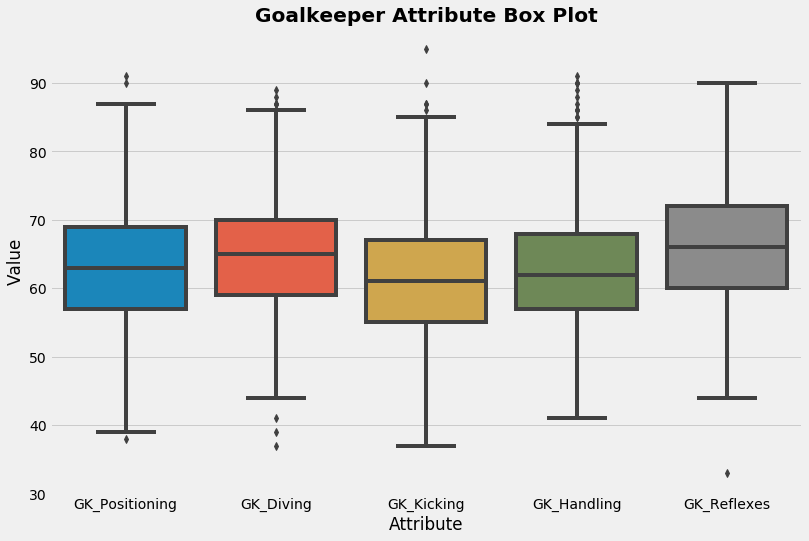

In [127]:
plt.figure(figsize=(12,8))
plt.title('Goalkeeper Attribute Box Plot', loc = 'center', weight = 'bold')
ax = sns.boxplot(x = 'Attribute', y = 'Value', data = df_gks_melt)

In [128]:
df_pl_att = pd.melt(df_players, id_vars = ['Name'], value_vars = shooting_att, var_name = 'Attribute', value_name = 'Value')

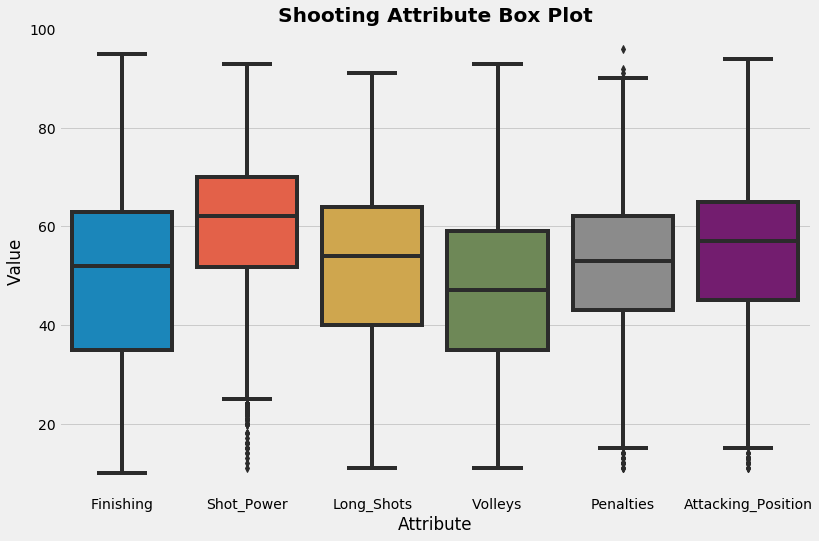

In [129]:
plt.figure(figsize=(12,8))
plt.title('Shooting Attribute Box Plot', loc = 'center', weight = 'bold')
ax = sns.boxplot(x = 'Attribute', y = 'Value', data = df_pl_att)

### Attributes by Position

In [130]:
pos_avgs = df_players.groupby('Position').mean()

Sort table using a manually defined sort: most attacking players to least.

In [131]:
positions = ['ST', 'RW', 'RM','LW', 'LM', 'CAM', 'CM', 'CDM', 'RB','LB', 'CB']
mapping = {pos: i for i, pos in enumerate(positions)}
pos_avgs['sorted'] = pos_avgs.index.map(mapper=(lambda x: mapping[x]))
pos_avgs.sort_values(by='sorted', ascending = True, inplace = True)
pos_avgs.head(11)

,Club_Kit,Contract_Expiry,Rating,Age,Weak_foot,Skill_Moves,Ball_Control,Dribbling,Marking,Sliding_Tackle,...,Jumping,Heading,Shot_Power,Finishing,Long_Shots,Curve,Freekick_Accuracy,Penalties,Volleys,sorted
Position,,,,,,,,,,,,,,,,,,,,,
ST,23.599085,2018.935976,66.087652,25.234375,3.071646,2.624238,64.382241,63.211509,22.611662,23.028963,...,67.606326,63.594893,66.708079,66.811738,59.872713,51.948552,45.398628,63.637195,58.903963,0
RW,23.803419,2019.176638,66.390313,23.455840,3.105413,3.094017,68.142450,69.860399,27.643875,30.022792,...,58.843305,49.202279,65.301994,61.891738,58.558405,58.561254,51.475783,58.472934,55.586895,1
RM,21.303554,2018.887608,66.645533,25.020173,3.146013,2.951009,66.963497,68.541787,34.040346,35.618636,...,62.169068,48.952930,63.867435,59.238232,58.698367,58.784822,52.512008,57.227666,53.980788,2
LW,23.860927,2018.917219,67.304636,24.165563,3.235099,3.102649,69.142384,71.072848,28.019868,29.791391,...,60.324503,50.013245,66.298013,62.417219,60.331126,60.172185,52.754967,58.960265,57.119205,3
LM,22.529781,2018.932079,66.980146,25.000000,3.129572,2.965517,67.626959,69.118077,33.471264,35.336468,...,61.612330,48.885057,64.589342,59.398119,59.081505,60.331243,54.065831,57.349007,54.355277,4
CAM,23.098361,2018.989982,67.184882,24.908925,3.211293,3.067395,68.720401,68.520036,36.093807,37.940801,...,59.994536,49.832423,63.822404,59.224954,60.708561,61.892532,58.746812,59.067395,55.592896,5
CM,20.782543,2018.857719,65.234107,24.784057,3.088799,2.504541,66.554995,63.682139,51.709889,54.721998,...,63.032795,52.725025,63.674571,51.771443,58.315338,56.661453,54.452573,54.545913,50.540363,6
CDM,19.868919,2019.026351,67.294595,26.231081,2.991892,2.193243,65.049324,59.493919,62.981081,63.445270,...,66.486486,58.304730,62.298649,45.199324,54.241216,50.980405,49.751351,51.813514,44.627027,7
RB,20.451909,2018.805516,65.871994,25.509901,2.905233,2.190948,61.109618,59.767327,63.359972,65.765912,...,67.937058,56.022631,52.706506,38.963932,43.924328,49.257426,41.591938,45.803395,39.047383,8


In [132]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [138]:
len(pos_avgs.columns)

36

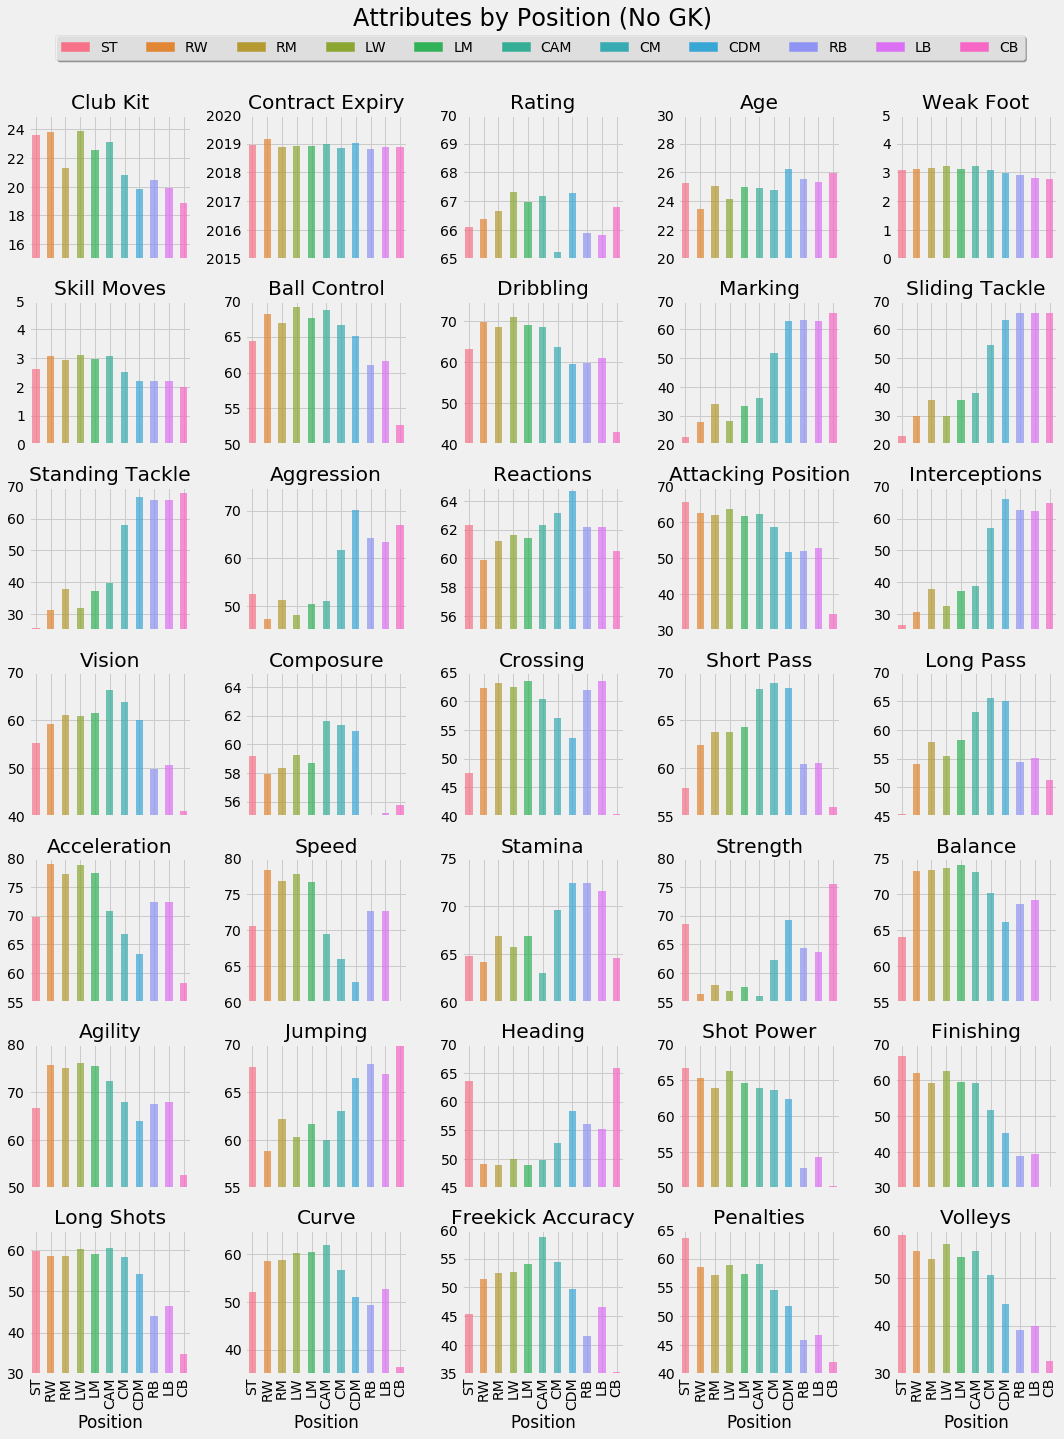

In [147]:
fig, axs = plt.subplots(nrows = 7,ncols = 5, figsize=(15,20), sharex = True)

plt.suptitle('Attributes by Position (No GK)', fontsize = 24, y = 1.)

y_axis_list = list(pos_avgs.columns)[:len(pos_avgs.columns)-1]
for i, col in enumerate(y_axis_list):
    row_num = i // 5
    col_num = i % 5
    max = pos_avgs[col].max()
    max = math.ceil(max/5)*5
    min = pos_avgs[col].min()
    min = math.floor(min/5)*5

    axs[row_num, col_num].set_ylim(min, max)
    pos_avgs[col].plot(kind='bar',
        ax = axs[row_num, col_num], color = sns.color_palette("husl", 11),
            title = col.replace('_', ' ').title(), alpha = 0.7)

        
patch_list = []
colors = sns.color_palette('husl', 11)

for i in range(len(positions)):
    patch_list.append(mpatches.Patch(color = colors[i], label = positions[i]))

plt.figlegend(handles = patch_list, labels = positions, loc = 'upper center',
              ncol = 11, bbox_to_anchor = (.5,.98), shadow = True)

plt.tight_layout()
plt.subplots_adjust(top = .925)

plt.savefig('attributes_by_position.png')

### Attributes by Nationality

In [151]:
df_nation = df_players.groupby(by='Nationality').mean()
count = df_players.groupby(by='Nationality')['Name'].count()
count.name = 'Count'
df_nation = pd.concat([df_nation, count], axis = 1, join_axes = [df_nation.index])
df_nation = df_nation[df_nation['Count']>100]

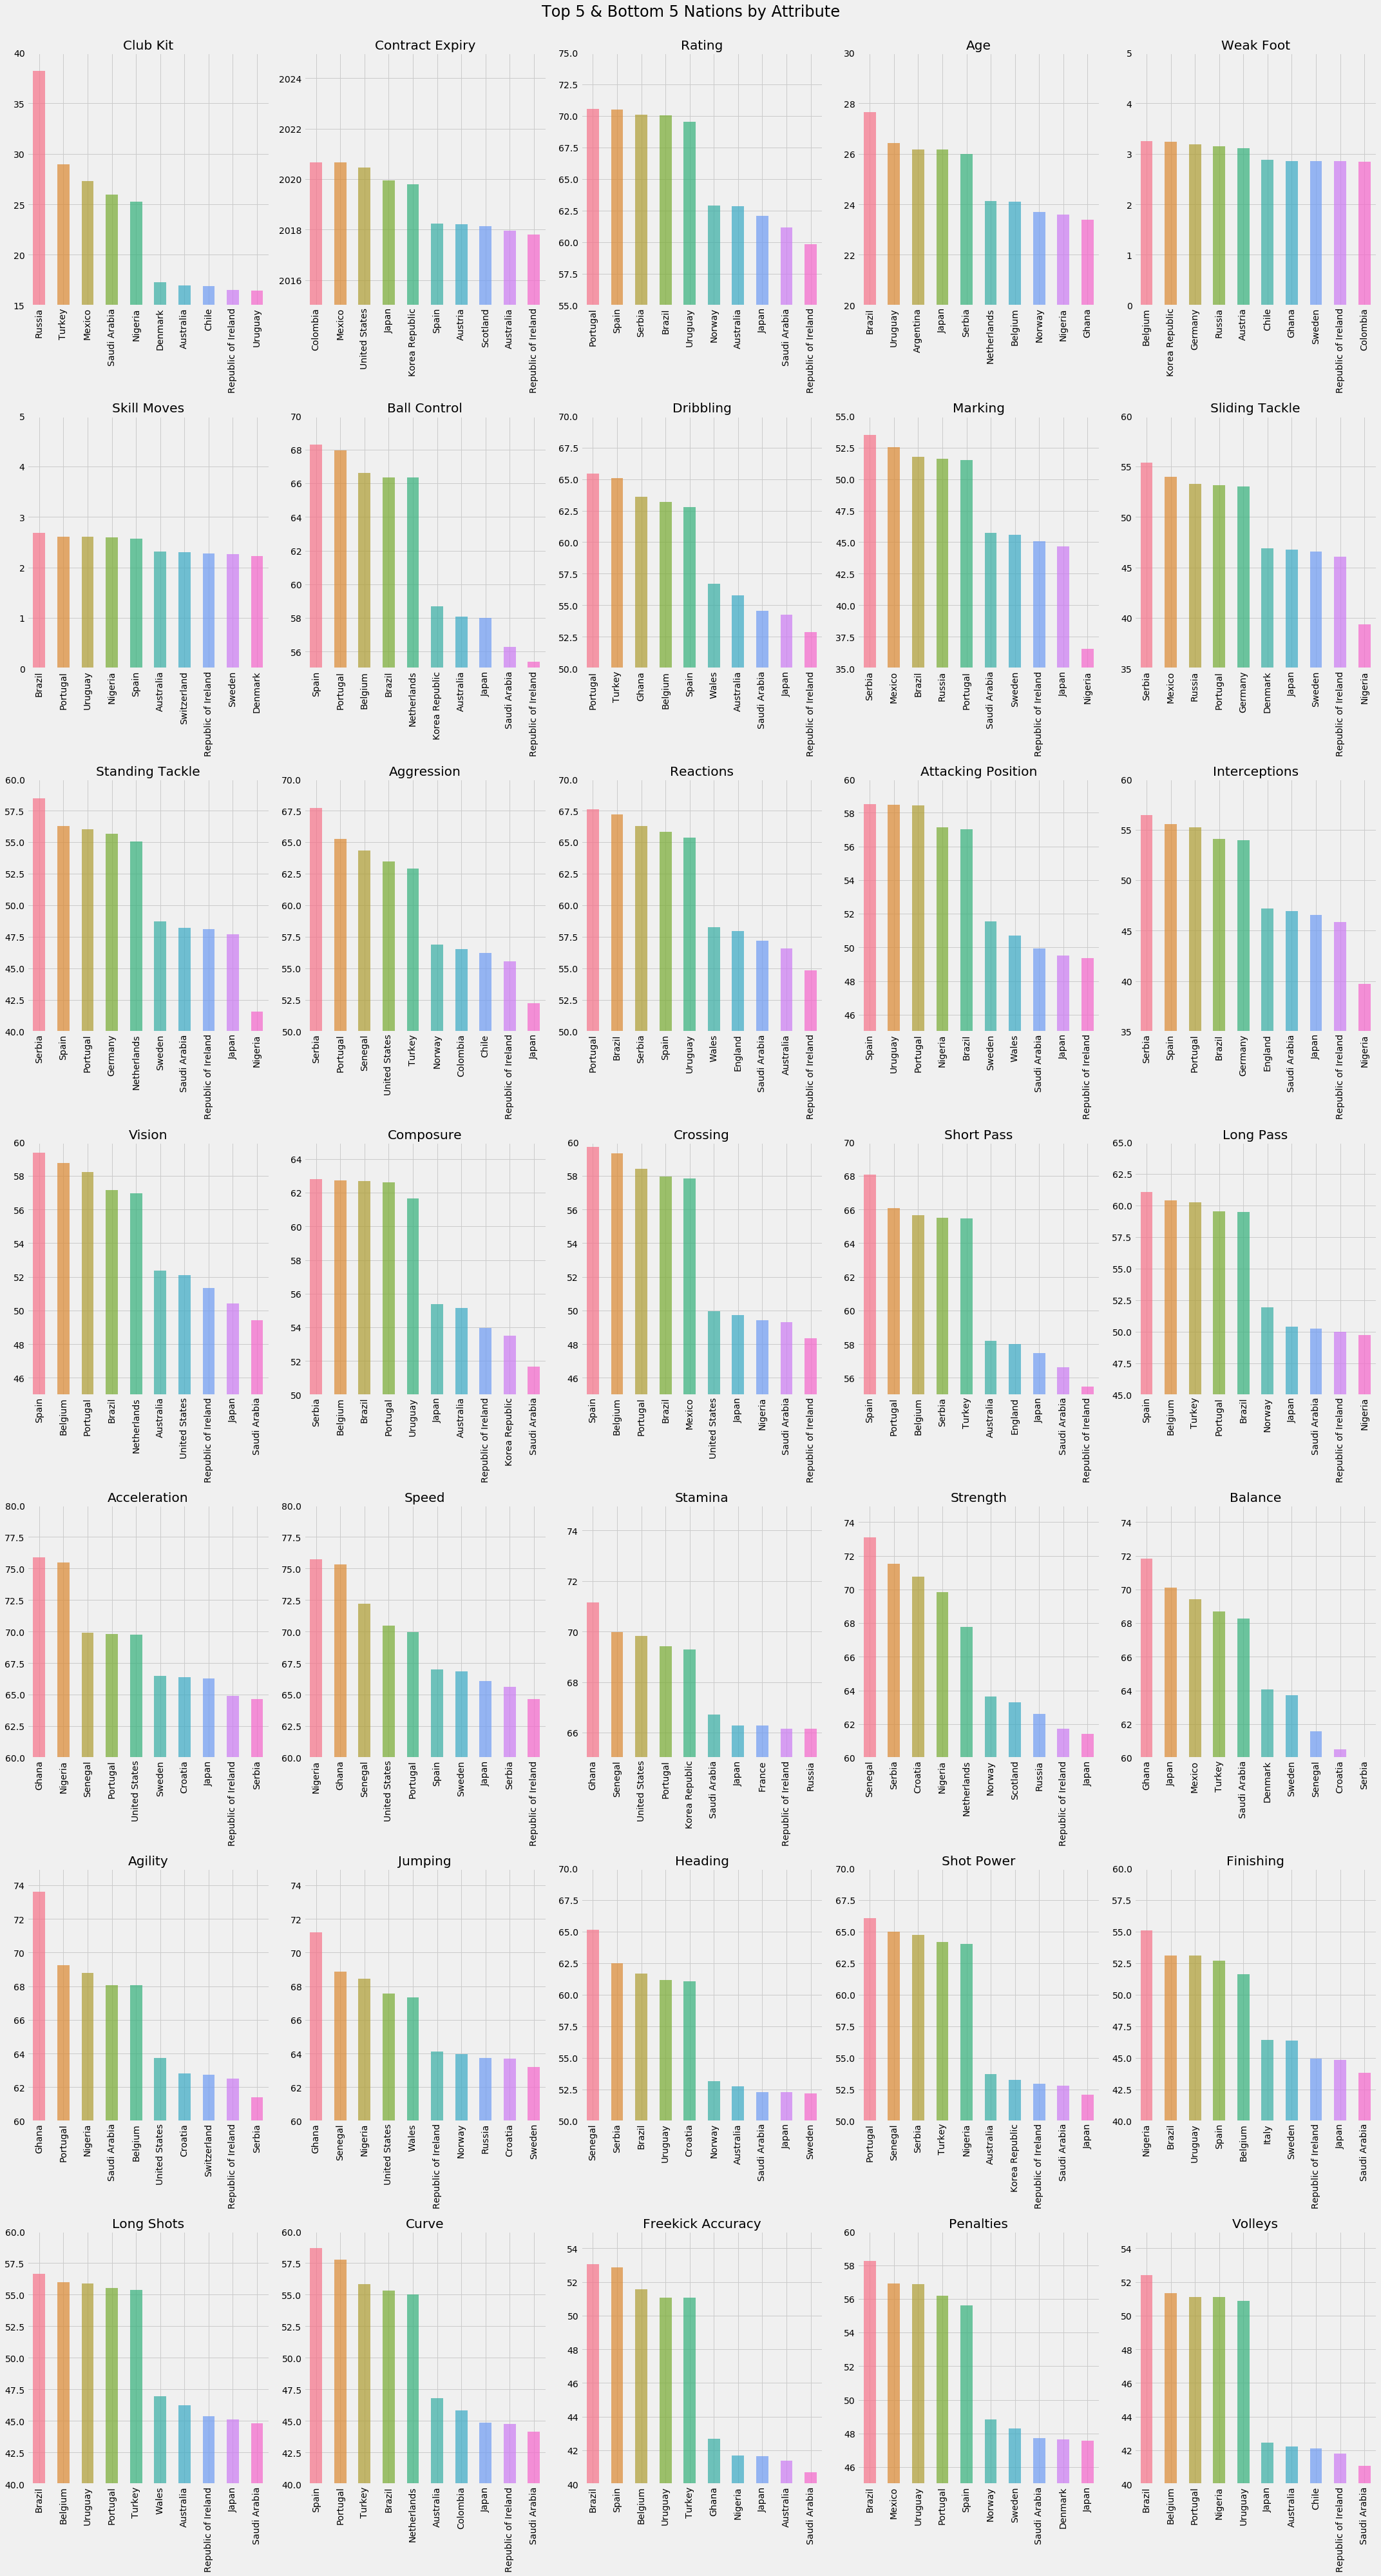

In [164]:
columns = list(df_nation.columns)[:len(df_nation.columns)-1]

fig, axs = plt.subplots(nrows = 7,ncols = 5, figsize=(30,55))
plt.suptitle('Top 5 & Bottom 5 Nations by Attribute', fontsize = 24, y=1.01)

i = 0
for col in columns:
    temp_sort = df_nation.sort_values(by=col, ascending = False)[col]
    temp_top = temp_sort.head(5)
    temp_bot = temp_sort.tail(5)
    temp = pd.concat([temp_top, temp_bot])
    
    nmax = temp.head(1)
    nmax = math.ceil(nmax/5)*5
    nmin = temp.tail(1)
    nmin = math.floor(nmin/5)*5
   
    nrow = i//5
    ncol = i%5
    i = i + 1
    
    axs[nrow, ncol].set_ylim(nmin, nmax)
    
    temp.plot(kind='bar', ax = axs[nrow, ncol], color = sns.color_palette("husl", 10),
            title = col.replace('_', ' ').title(), alpha = 0.7)
    
    axs[nrow, ncol].get_xaxis().get_label().set_visible(False)
    
plt.subplots_adjust(top = .7)
plt.tight_layout()
    

In [165]:
df_nation = df_nation.rank(ascending = False)
df_nation.head(10)

,Club_Kit,Contract_Expiry,Rating,Age,Weak_foot,Skill_Moves,Ball_Control,Dribbling,Marking,Sliding_Tackle,...,Jumping,Heading,Shot_Power,Finishing,Long_Shots,Curve,Freekick_Accuracy,Penalties,Volleys,Count
Nationality,,,,,,,,,,,,,,,,,,,,,
Argentina,29.0,8.0,14.0,3.0,29.0,7.0,14.0,12.0,22.0,23.0,...,14.0,7.0,15.0,10.0,11.0,11.0,10.0,8.0,17.0,2.0
Australia,32.0,34.0,32.0,29.0,23.0,31.0,32.0,32.0,19.0,22.0,...,29.0,32.0,31.0,27.0,32.0,31.0,34.0,28.0,32.0,27.0
Austria,12.0,32.0,22.0,24.0,5.0,21.0,22.0,22.0,20.0,20.0,...,28.0,19.0,23.0,19.0,20.0,16.0,19.0,27.0,22.0,25.0
Belgium,6.0,23.0,8.0,32.0,1.0,6.0,3.0,4.0,25.0,21.0,...,10.0,17.0,8.0,5.0,2.0,9.0,3.0,9.0,2.0,26.0
Brazil,27.0,9.0,4.0,1.0,18.0,1.0,4.0,6.0,3.0,8.0,...,30.0,3.0,6.0,2.0,1.0,4.0,1.0,1.0,1.0,5.0
Chile,33.0,6.0,20.0,19.0,31.0,10.0,20.0,19.0,13.0,19.0,...,23.0,24.0,27.0,29.0,23.0,29.0,21.0,26.0,33.0,12.0
Colombia,28.0,1.0,19.0,17.0,35.0,11.0,25.0,24.0,26.0,30.0,...,7.0,21.0,28.0,22.0,25.0,32.0,29.0,25.0,28.0,8.0
Croatia,9.0,13.5,7.0,18.0,8.0,14.0,16.0,17.0,16.0,11.0,...,34.0,5.0,18.0,15.0,16.0,19.0,14.0,15.0,15.0,35.0
Denmark,31.0,17.0,28.0,25.0,14.0,35.0,23.0,30.0,30.0,31.0,...,27.0,25.0,25.0,26.0,28.0,25.0,26.0,34.0,24.0,17.0


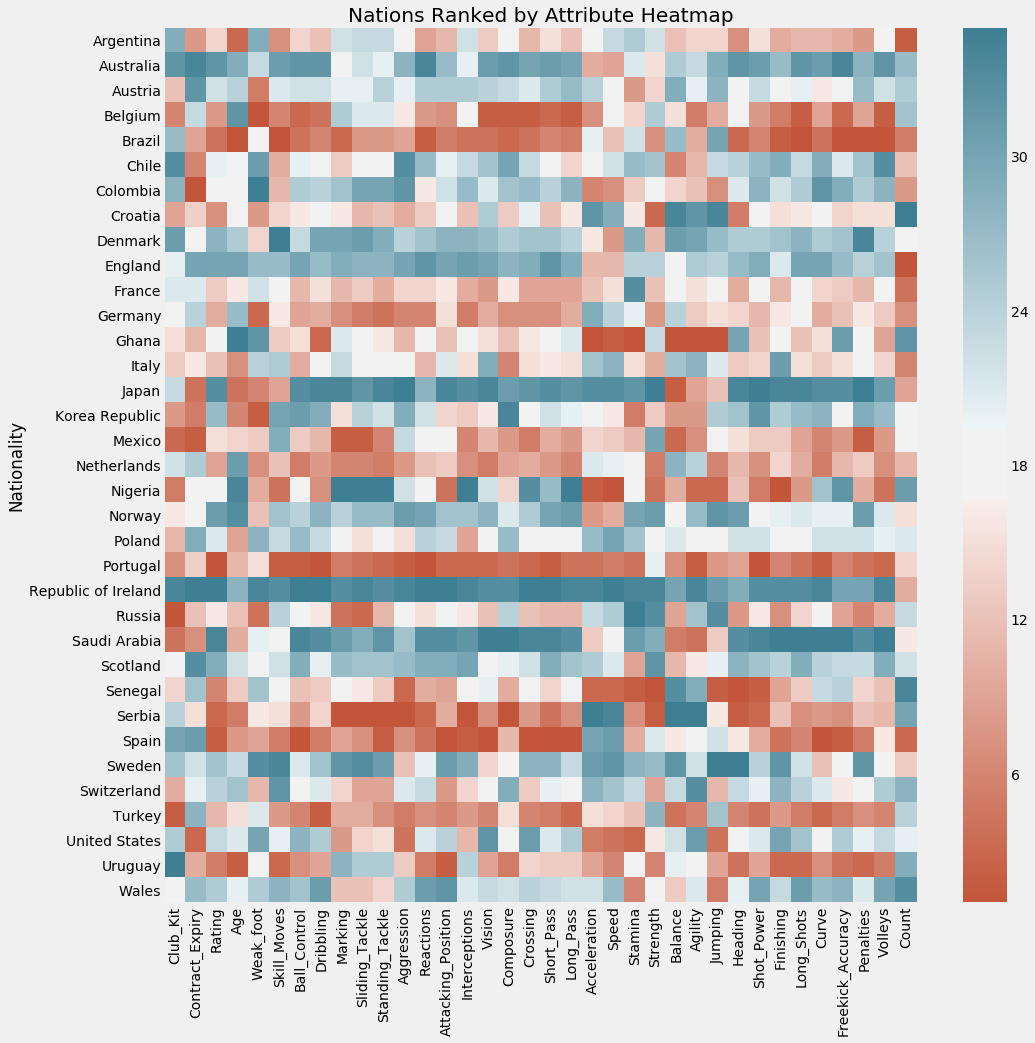

In [179]:
plt.figure(figsize = (15,15))
plt.title('Nations Ranked by Attribute Heatmap')
cmap = sns.diverging_palette(20, 220, sep=20, as_cmap=True)
ax = sns.heatmap(df_nation, center = 18, cmap = cmap, vmin = 1, vmax = 35, robust = True)